In [1]:
import os
import gc

os.chdir('../../')

In [47]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss
import joblib
from venn_abers import VennAbersCalibrator
from global_code.util import clf_metric_report, plot_pr_calib_curve, plot_dis_probs
import json

### Load the calibration data

In [3]:
train_df = pd.read_parquet('./week_1/data/processed/train_df.parquet')
validation_df = pd.read_parquet('./week_1/data/processed/validation_df.parquet')
calibration_df = pd.read_parquet('./week_1/data/processed/calibration_df.parquet')
cat_features = ['country', 'broad_job_category']

target = 'churn_420'

# Input variables and Target dataframes
X_train, y_train= train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (306649, 152) (306649,)
Validation shape:  (283510, 152) (283510,)
Calibration shape:  (70878, 152) (70878,)


### Load the tuned model

In [6]:
tunned_model_path = './week_1/model/tunned_model.joblib'
tunned_model = joblib.load(tunned_model_path)
tunned_model

In [5]:
selected_features = None
with open('./week_1/model/selected_features_list.json', 'r') as f:
    selected_features = json.load(f)
print(selected_features)

['interest_rate', 'tenure', 'prior_crypto_balance', 'prior_mean_balance', 'prior_sum_days_between', 'prior_std_days_between', 'prior_mean_days_between', 'prior_max_days_between', 'prior_mean_bank_transfer_in', 'prior_mean_bank_transfer_out', 'prior_mean_crypto_out', 'prior_mean_bank_transfer_in_volume', 'prior_mean_crypto_in_volume', 'prior_sum_crypto_in_volume', 'prior_sum_crypto_out_volume', 'prior_10D_std_days_between', 'prior_10D_mean_bank_transfer_out', 'prior_90D_mean_days_between', 'prior_90D_std_days_between', 'prior_90D_min_days_between', 'prior_90D_mean_bank_transfer_out', 'prior_90D_mean_bank_transfer_in_volume', 'prior_90D_mean_crypto_out_volume', 'prior_180D_sum_days_between', 'prior_180D_mean_days_between', 'prior_180D_max_days_between', 'prior_180D_min_days_between', 'prior_180D_mean_balance', 'prior_365D_sum_days_between', 'prior_365D_mean_days_between', 'prior_365D_std_days_between', 'prior_365D_min_days_between', 'prior_365D_mean_crypto_in_volume', 'prior_450D_sum_day

### Calibrate the model using Platt scaling (sigmoid) and isotonic regression

In [10]:
# Platt scaling (sigmoid)
print('Fitting platt scaling calibration...')
calibrated_model_sigmoid = CalibratedClassifierCV(tunned_model, method='sigmoid')
calibrated_model_sigmoid.fit(X_calibration[selected_features], y_calibration)
y_pred_sigmoid = calibrated_model_sigmoid.predict_proba(X_validation[selected_features])[:, 1]


Fitting platt scaling calibration...
0:	learn: 0.0317457	total: 24ms	remaining: 18s
1:	learn: 0.0362087	total: 57.4ms	remaining: 21.5s
2:	learn: 0.0382532	total: 124ms	remaining: 31s
3:	learn: 0.0391887	total: 146ms	remaining: 27.3s
4:	learn: 0.0413543	total: 168ms	remaining: 25.1s
5:	learn: 0.0420460	total: 194ms	remaining: 24.1s
6:	learn: 0.0435226	total: 216ms	remaining: 22.9s
7:	learn: 0.0427417	total: 237ms	remaining: 22s
8:	learn: 0.0431758	total: 260ms	remaining: 21.4s
9:	learn: 0.0432758	total: 282ms	remaining: 20.8s
10:	learn: 0.0438326	total: 305ms	remaining: 20.5s
11:	learn: 0.0440432	total: 325ms	remaining: 20s
12:	learn: 0.0442767	total: 347ms	remaining: 19.7s
13:	learn: 0.0442120	total: 366ms	remaining: 19.2s
14:	learn: 0.0449625	total: 384ms	remaining: 18.8s
15:	learn: 0.0473662	total: 402ms	remaining: 18.5s
16:	learn: 0.0463526	total: 422ms	remaining: 18.2s
17:	learn: 0.0461202	total: 442ms	remaining: 18s
18:	learn: 0.0458578	total: 462ms	remaining: 17.8s
19:	learn: 0.0

In [11]:
# Isotonic regression
print('Fitting isotonic regression calibration...')
calibrated_model_isotonic = CalibratedClassifierCV(tunned_model, method='isotonic')
calibrated_model_isotonic.fit(X_calibration[selected_features], y_calibration)
y_pred_isotonic = calibrated_model_isotonic.predict_proba(X_validation[selected_features])[:, 1]

Fitting isotonic regression calibration...
0:	learn: 0.0317457	total: 22.5ms	remaining: 16.9s
1:	learn: 0.0362087	total: 40.1ms	remaining: 15s
2:	learn: 0.0382532	total: 57.8ms	remaining: 14.4s
3:	learn: 0.0391887	total: 79.5ms	remaining: 14.8s
4:	learn: 0.0413543	total: 98.3ms	remaining: 14.7s
5:	learn: 0.0420460	total: 116ms	remaining: 14.4s
6:	learn: 0.0435226	total: 136ms	remaining: 14.5s
7:	learn: 0.0427417	total: 156ms	remaining: 14.5s
8:	learn: 0.0431758	total: 175ms	remaining: 14.4s
9:	learn: 0.0432758	total: 194ms	remaining: 14.3s
10:	learn: 0.0438326	total: 213ms	remaining: 14.3s
11:	learn: 0.0440432	total: 232ms	remaining: 14.3s
12:	learn: 0.0442767	total: 256ms	remaining: 14.5s
13:	learn: 0.0442120	total: 274ms	remaining: 14.4s
14:	learn: 0.0449625	total: 292ms	remaining: 14.3s
15:	learn: 0.0473662	total: 310ms	remaining: 14.2s
16:	learn: 0.0463526	total: 331ms	remaining: 14.3s
17:	learn: 0.0461202	total: 357ms	remaining: 14.5s
18:	learn: 0.0458578	total: 378ms	remaining: 1

In [13]:
# Compute metrics for Platt scaling and isotonic regression
print("Platt Scaling (Sigmoid) Metrics:")
clf_metric_report(y_pred_sigmoid, y_validation)

print("\nIsotonic Regression Metrics:")
clf_metric_report(y_pred_isotonic, y_validation)

Platt Scaling (Sigmoid) Metrics:
Evaluating the model...


ROC AUC: 0.702551263693548
Brier Score: 0.013633964653638107
Average Precision: 0.03178041231771329
Log Loss: 0.06976345742891699

Isotonic Regression Metrics:
Evaluating the model...
ROC AUC: 0.7021398462856687
Brier Score: 0.013633779264664019
Average Precision: 0.031599854358104834
Log Loss: 0.06948929266377843


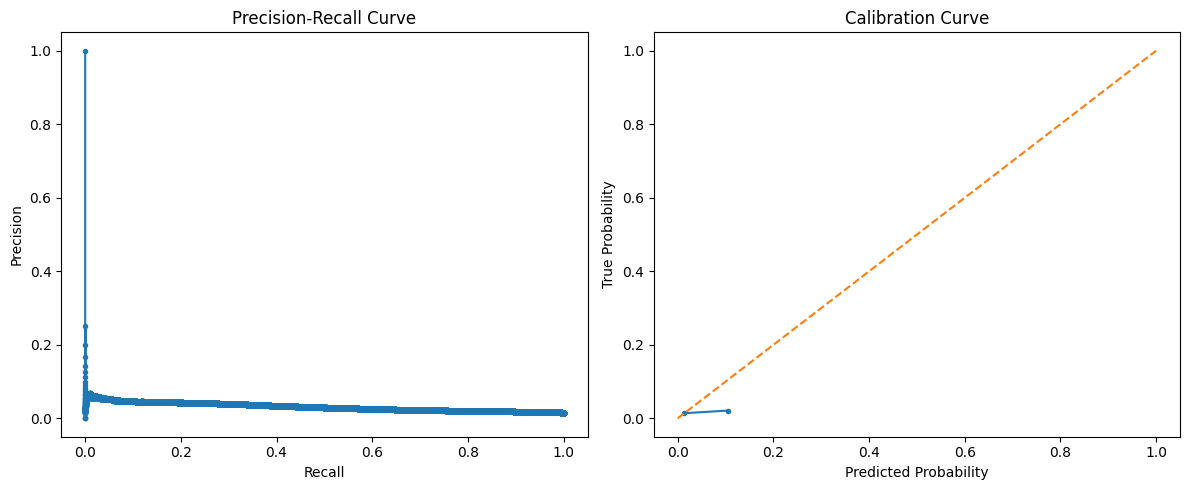

In [18]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_sigmoid, y_validation)

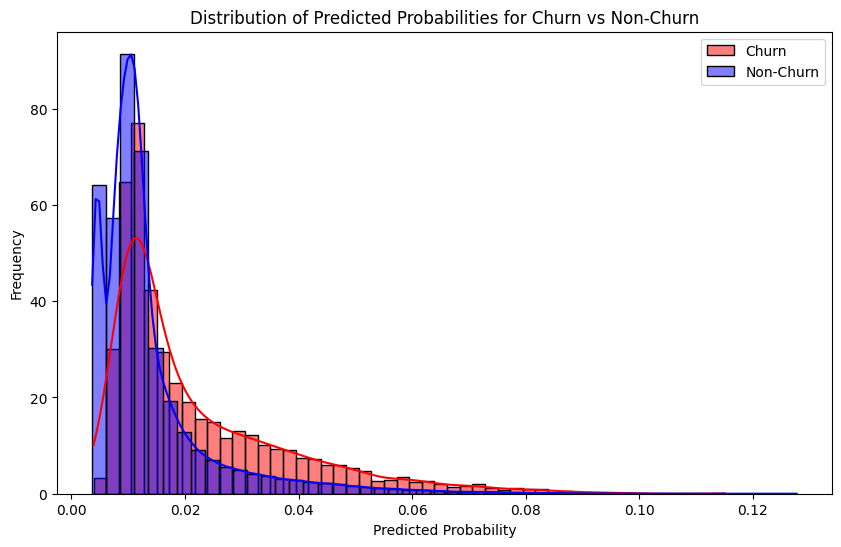

In [48]:
# PR Curve and Calibration curve
plot_dis_probs(y_pred_sigmoid, y_validation)

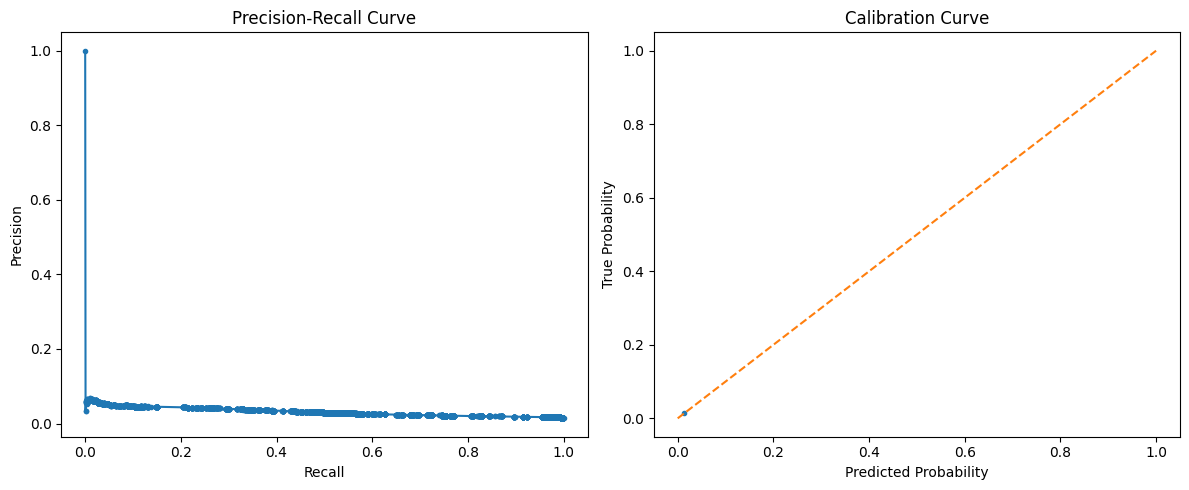

In [19]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_isotonic, y_validation)

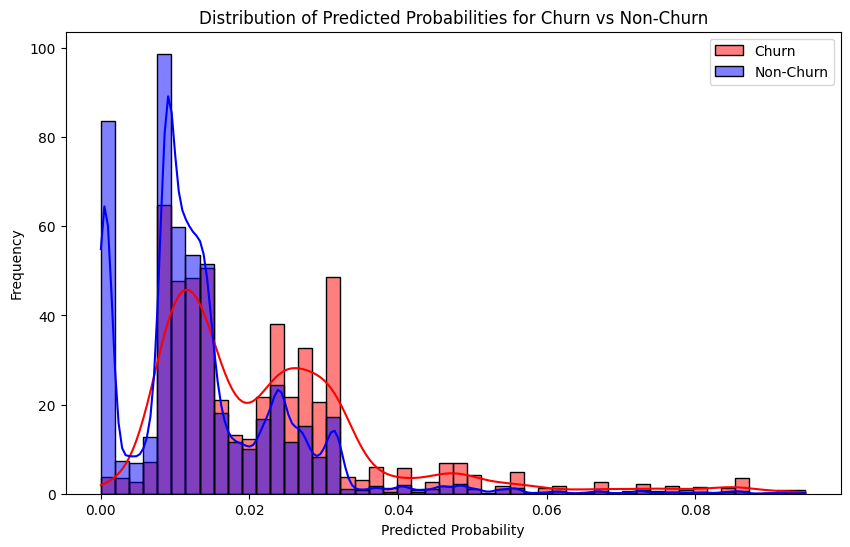

In [49]:
plot_dis_probs(y_pred_isotonic, y_validation)

### Calibrate the model using Venn-Abers

In [58]:
p_cal = tunned_model.predict_proba(X_calibration[selected_features])
p_test = tunned_model.predict_proba(X_validation[selected_features])

va = VennAbersCalibrator()
va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_calibration.values, p_test=p_test)
y_pred_va = va_prefit_prob[:, 1]

/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/venn_abers/venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


In [59]:
# Compute metrics for Venn-Abers calibration
print("\nVenn-Abers Calibration Metrics:")
clf_metric_report(y_pred_va, y_validation)



Venn-Abers Calibration Metrics:
Evaluating the model...
ROC AUC: 0.6882041505931193
Brier Score: 0.013654988468059532
Average Precision: 0.028552523230546512
Log Loss: 0.06977451794831688


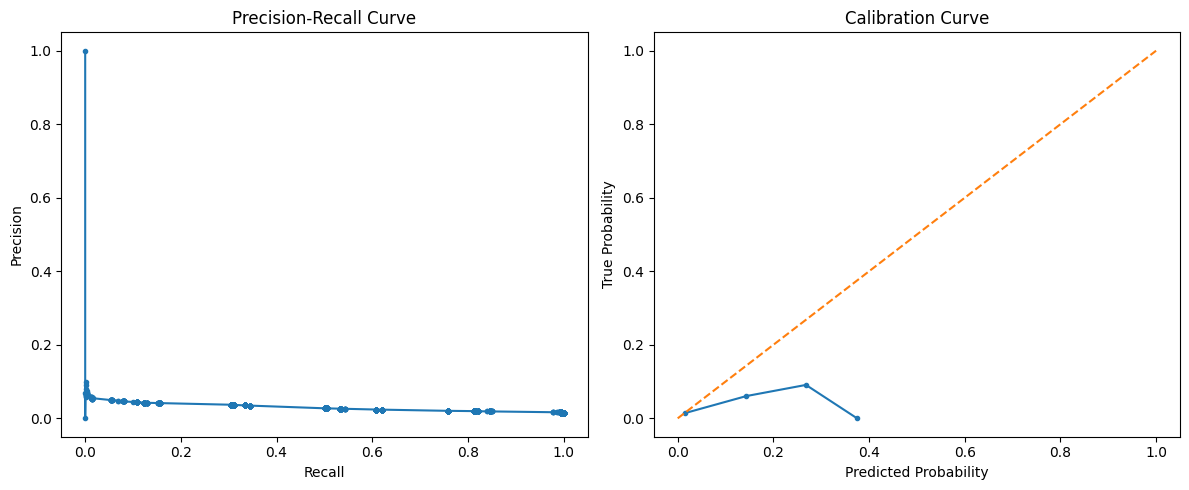

In [60]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_va, y_validation)

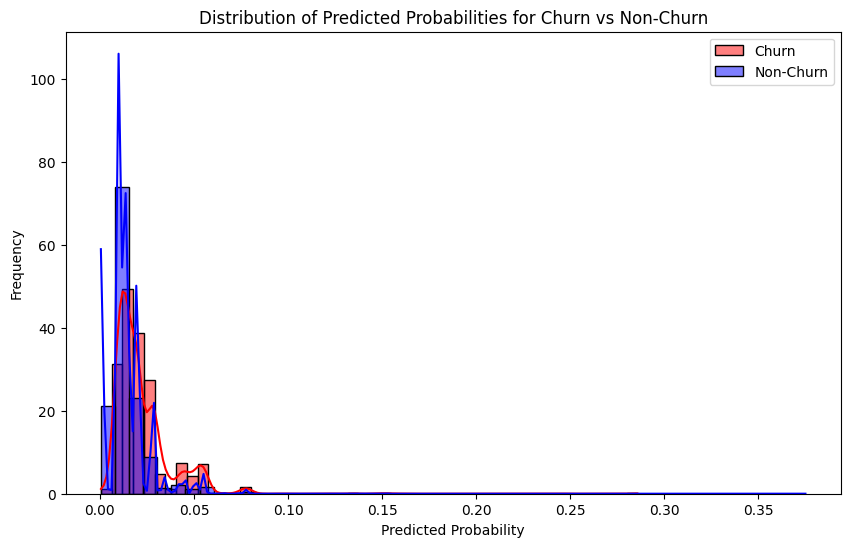

In [61]:
plot_dis_probs(y_pred_va, y_validation)

### Compare the models

In [45]:
# Load the baseline and feature selection models
baseline_model_path = './week_1/model/baseline_model.joblib'
feat_selection_model_path = './week_1/model/feat_selection_model.joblib'

baseline_model = joblib.load(baseline_model_path)
feat_selection_model = joblib.load(feat_selection_model_path)

# Predict using the baseline model
y_pred_baseline = baseline_model.predict_proba(X_validation)[:, 1]

# Predict using the feature selection model
y_pred_feat_selection = feat_selection_model.predict_proba(X_validation[selected_features])[:, 1]


# Predict using the tunned model
y_pred_tunned= tunned_model.predict_proba(X_validation[selected_features])[:, 1]

# Compare the models using clf_metric_report
print("Baseline Model Metrics:")
clf_metric_report(y_pred_baseline, y_validation)

print("\nFeature Selection Model Metrics:")
clf_metric_report(y_pred_feat_selection, y_validation)

print("\nTuned Model Metrics:")
clf_metric_report(y_pred_tunned, y_validation)

print("\nPlatt Scaling (Sigmoid) Metrics:")
clf_metric_report(y_pred_sigmoid, y_validation)

print("\nIsotonic Regression Metrics:")
clf_metric_report(y_pred_isotonic, y_validation)

print("\nVenn-Abers Calibration Metrics:")
clf_metric_report(y_pred_va, y_validation)

Baseline Model Metrics:
Evaluating the model...
ROC AUC: 0.6874491984817513
Brier Score: 0.27357068114462263
Average Precision: 0.02813379957569347
Log Loss: 0.7299075239299322

Feature Selection Model Metrics:
Evaluating the model...
ROC AUC: 0.6932547527225034
Brier Score: 0.2562781920929616
Average Precision: 0.02992709580252091
Log Loss: 0.7023102442145577

Tuned Model Metrics:
Evaluating the model...
ROC AUC: 0.6887885317809944
Brier Score: 0.18035795402906535
Average Precision: 0.030131135261490048
Log Loss: 0.5523835700098298

Platt Scaling (Sigmoid) Metrics:
Evaluating the model...
ROC AUC: 0.702551263693548
Brier Score: 0.013633964653638107
Average Precision: 0.03178041231771329
Log Loss: 0.06976345742891699

Isotonic Regression Metrics:
Evaluating the model...
ROC AUC: 0.7021398462856687
Brier Score: 0.013633779264664019
Average Precision: 0.031599854358104834
Log Loss: 0.06948929266377843

Venn-Abers Calibration Metrics:
Evaluating the model...
ROC AUC: 0.6882041505931193
Br